In [1]:
import numpy as np
import torch
from pathlib import Path
from noise2inverse import tiffs, noise, fig
from noise2inverse.datasets import (
    TiffDataset,
    Noise2InverseDataset,
)
import tomosipo as ts
import tomopy
import tifffile
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Parameters
input_dir = Path("reconstructions")
weights_path = Path("weights/weights.torch")
output_dir = Path("denoised")

num_splits = 4
strategy = "X:1"
batch_size = num_splits

# Use network whose parameters are stored in weights/weights.torch
# By default that is an msd network
network = "msd" # msd or unet or dncnn
multi_gpu = True

# Scale pixel intensities in the same way as during training.
data_scaling = 200

In [3]:
# Output dir
output_dir.mkdir(exist_ok=True)

In [4]:
datasets = [TiffDataset(input_dir / f"{j}/*.tif") for j in range(num_splits)]
ds = Noise2InverseDataset(*datasets, strategy=strategy)

In [5]:
# Dataloader and network:
dl = DataLoader(ds, batch_size, shuffle=False,)

In [6]:
# Option a) Use MSD network
if network == "msd":
    from msd_pytorch import MSDRegressionModel
    model = MSDRegressionModel(1, 1, 100, 1, parallel=multi_gpu)
    net = model.net

# Option b) Use UNet
if network == "unet":
    from noise2inverse import UNet
    net = UNet(1, 1) # 1 input channel, 1 output channel
    if multi_gpu:
        net = nn.DataParallel(net)

# Option c) Use DnCNN
if network == "dncnn":
    from noise2inverse import DnCNN
    net = DnCNN(1) # 1 input channel, 1 output channel
    if multi_gpu:
        net = nn.DataParallel(net)
        
# Load weights
state = torch.load(weights_path)
net.load_state_dict(state["state_dict"])
net = net.cuda()

In [7]:
# Put network in evaluation mode: this should be done when the network uses batch norm for instance.
net.eval()
with torch.no_grad():
    for i, batch in tqdm(enumerate(dl)):
        inp, _ = batch     
        inp = inp.cuda() * data_scaling
        out = net(inp)
        # Take mean over batch dimension (splits):
        out = out.mean(dim=0) / data_scaling
        # Obtain 2D numpy array
        out_np = out.detach().cpu().numpy().squeeze()
        out_path = str(output_dir / f"output_{i:05d}.tif")
        tifffile.imsave(out_path, out_np)

512it [02:23,  3.56it/s]


/export/scratch1/hendriks/projects/noise2inverse/noise2inverse/fig.py:111: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  data=None,              # This is another way to present args..


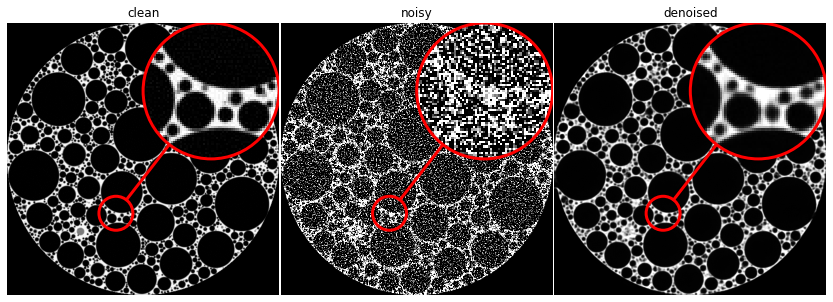

In [8]:
fig.plot_imgs(
    clean=tifffile.imread("./reconstructions/clean/output_00256.tif"),
    noisy=tifffile.imread("./reconstructions/noisy/output_00256.tif"),
    denoised=tifffile.imread("./denoised/output_00256.tif"),
    vmin=0,
    vmax=0.004,
    width=15,
)
import matplotlib.patches as patches

axes = plt.gcf().axes
for ax in axes[:3]:
    fig.add_zoom_bubble(ax.images[0], roi=(.4, .3), zoom=4, inset_radius=.25)